**Students names :** TO BE COMPLETED

# TP 1 : JPEG image compression

This multimedia tutorial is done in Python3, using the scikit-image library. The arrays used by this library to manipulate the images (ndarray) come from the numpy library. The documentation of these two libraries will be very useful.

**Note**: All the scripts of this tutorial work by default on an example image (a cat...), but other images are also provided with the tutorial so that you can evaluate the algorithms in various situations. You can also use your own images.

## Introduction: the principles of JPEG compression

The figure below shows the different steps involved in compressing and decompressing images in JPEG format. In this tutorial, we will not look at all of these operations in detail, but we will nevertheless focus on the fundamental concepts of JPEG (in particular the use of the Discrete Cosine Transform (DCT), quantization, as well as the coding of the resulting coefficients).

![Mon image d'illustration](figure/jpeg-encoder.gif)

## Downsampling

A simple way to reduce the amount of information in an image is to downsample it (i.e. reduce its size). This is what the script below does: we downsample (compress), then upsample (decompress) an image with different methods.


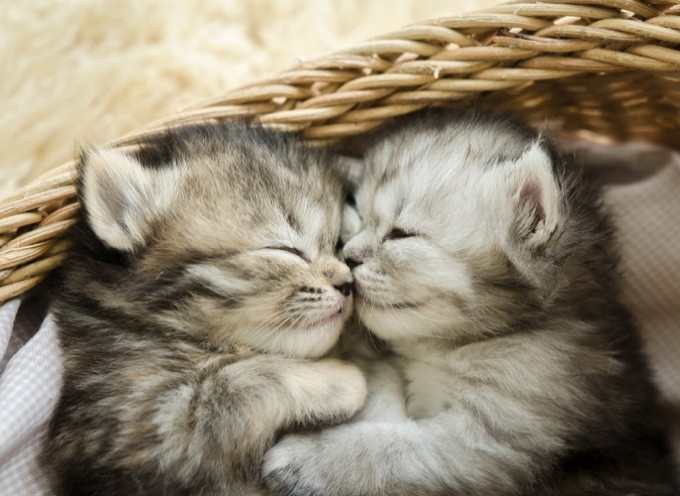


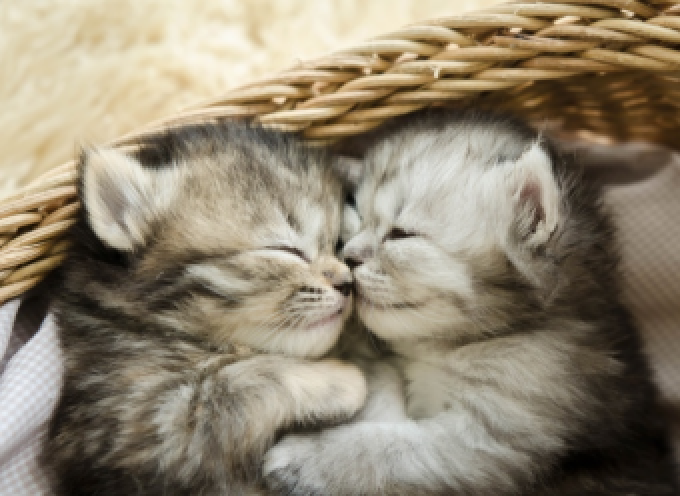


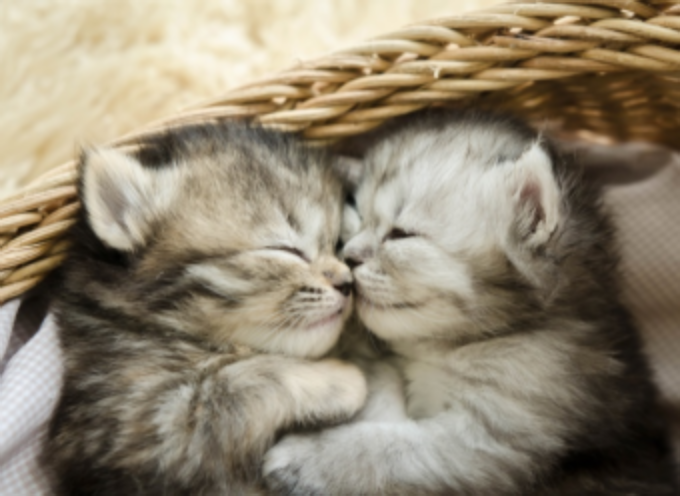


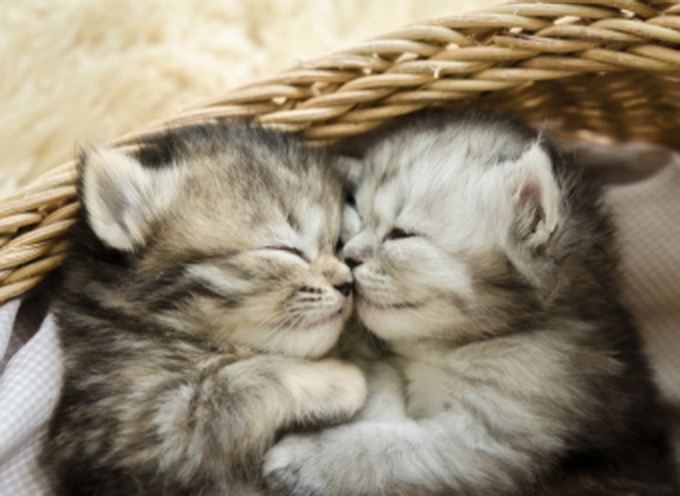

PSNR after global downscaling then upscaling (nearest neighbour):  32.56801899292042
PSNR after global downscaling then upscaling:  33.71957356654805
PSNR after global downscaling then upscaling:  35.76928610314233


In [2]:
# lets import the needed packages for the whole tutorial
import numpy as np
import random
from skimage import io
from skimage import transform
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from skimage import color
from skimage import metrics
from scipy import fftpack

# helps displaying matrices in a "nicer" way
np.set_printoptions(suppress=True)
np.set_printoptions(precision=0)
np.set_printoptions(threshold=1000)

# a sub-figure
fig = make_subplots(rows=2, cols=2)

# lets load an image
image = io.imread('./chat.jpg')

# we resize the image to a multiple width and height of 8 (this will ease later processings)
image = transform.resize(image,(image.shape[0]//8*8,image.shape[1]//8*8))
fig = px.imshow(image)
fig.update_layout( title_text="Image originale", title_x=0.5)
fig.show()
width=image.shape[1]
height=image.shape[0]

# the downscale factor
downscale = 2

# downsampling of the image 
downsampled=transform.resize(image,(height//downscale,width//downscale))

# then upscaling (with different methods)
subsampled0=transform.resize(downsampled,(height,width),order=0)
subsampled1=transform.resize(downsampled,(height,width),order=1)
subsampled2=transform.resize(downsampled,(height,width),order=3)

# We display the images and PSNR values
fig = px.imshow(subsampled0)
fig.update_layout( title_text="Nearest neighbour", title_x=0.5)
fig.show()
fig = px.imshow(subsampled1)
fig.update_layout( title_text="Bilinear interpolation", title_x=0.5)
fig.show()
fig = px.imshow(subsampled2)
fig.update_layout( title_text="Bicubic interpolation", title_x=0.5)
fig.show()
print("PSNR after global downscaling then upscaling (nearest neighbour): ", metrics.peak_signal_noise_ratio(image,subsampled0))
print("PSNR after global downscaling then upscaling: ", metrics.peak_signal_noise_ratio(image,subsampled1))
print("PSNR after global downscaling then upscaling: ", metrics.peak_signal_noise_ratio(image,subsampled2))

**Question 1**: Test different subsampling factors (e.g. 2, 4, 8). 

1. For each, what is the compression ratio and the PSNR obtained?
2. Is the quality obtained good (you will find some reminders about PSNR here https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio) ?

**Answer 1:**

The downsampling of the whole image may be a bit excessive... We can however take advantage of certain characteristics of our visual system to reduce the amount of data by downsampling in a less visible way. For this we will use a color space different from the classic RGB. We will use here the LUV space (JPEG uses the YCrCb / YUV space, quite close but not supported by scikit-image).


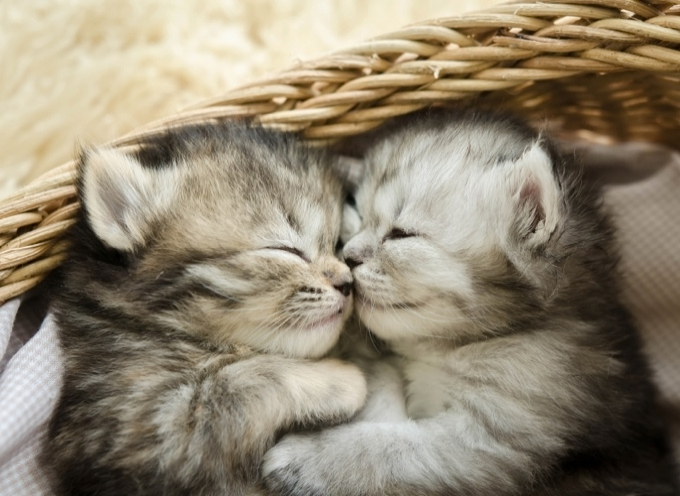

PSNR after downsampling then upsampling of chrominance channels:  50.43324323215806


In [3]:
# the downscaling factor
downscale = 2

# we use a more appropriate color space
# and only downsample chrominance channels
imageYUV = color.rgb2luv(image)

L=imageYUV[:,:,0]
U=imageYUV[:,:,1]
V=imageYUV[:,:,2]

# downsampling of U and V channels
U=transform.resize(U,(height//downscale,width//downscale))
V=transform.resize(V,(height//downscale,width//downscale))
# then upscaling
U=transform.resize(U,(height,width))
V=transform.resize(V,(height,width))
# we reconstruct the image from the different channels
subsampled=imageYUV.copy()
subsampled[:,:,1] = U
subsampled[:,:,2] = V
subsampled = color.luv2rgb(subsampled)
fig = px.imshow(subsampled)
fig.update_layout( title_text="Chrominance downsampling", title_x=0.5)
fig.show()

print("PSNR after downsampling then upsampling of chrominance channels: ", metrics.peak_signal_noise_ratio(image,subsampled))

**Question 2:** 

1. As in question 1, vary the downsampling factor and observe the image quality obtained (visually and via PSNR). Also indicate the compression ratio obtained. 
2. Explain the results obtained (in particular, what is the difference between RGB and YUV and how does it affect the image quality). Remember to test the clown.jpg image, which is more colorful than the cats...

**Answer 2:** 

## DCT

We saw in the course of signal and image processing that it was possible to represent an image not by spatial information, but by frequency information. The Discrete Fourier Transform (DFT or FFT) allows to perform this transformation, but it is not the only one. The discrete cosine transform (DCT) is another one which has interesting properties.

**Note**: to simplify things we will work on gray level images, but the principles seen in this section can be extended simply by working on each of the 3 color channels of the image (Y, Cb and Cr in the case of JPEG).

In [4]:
from scipy import fftpack

# lets display the DCT base functions on 8x8 blocks
fig = make_subplots(rows=8, cols=8)
for i in range (0,8):
    for j in range(0,8):
        a=np.zeros((8,8))
        a[i,j]=1
        # the 2D DCT is performed as a series of 1D DCT
        ia=fftpack.idct(fftpack.idct(a).T).T
        #ax[i,j].imshow(ia,cmap='gray')
        fig.add_trace(px.imshow(ia, binary_string=True).data[0], row=1+i, col=1+j)
fig.update_xaxes(visible=False) 
fig.update_yaxes(visible=False) 
fig.show()

**Question 3:** 
1. Examine and explain the DCT base functions generated by the above script.
2. Among the DCT on 8x8 blocks done in JPEG and the discrete Fourier transform that one would apply globally on the image, which transform(s):
- Allows the analysis of the energy distribution according to frequencies?
    - Provide information on the location in the image of these frequencies?
3. Which other tool better addresses this problem of simultaneous localization and frequency analysis? Is it used in some image compression formats?

**Answer 3:**

The following script calculates the DCT coefficients of all the 8x8 blocks of our image.


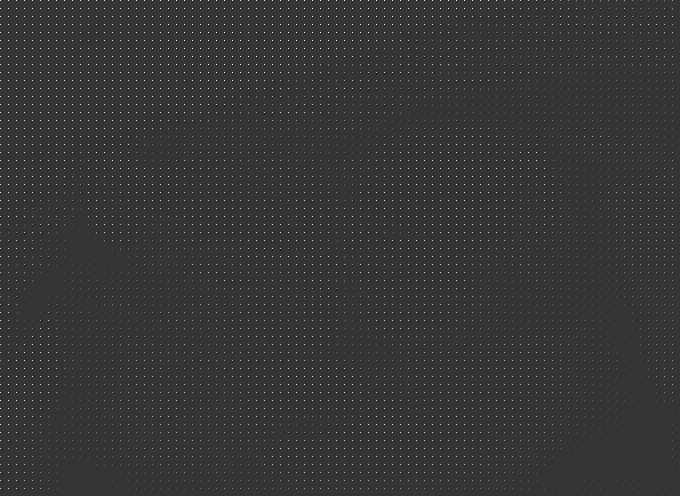

DCT coefficients of one DCT block
[[ 685.  -23.  -28.  -10.   -0.  -12.   15.    7.]
 [-215.   59.  -19.  -22.   -7.   -0.  -23.   -8.]
 [  25.   -0.   11.   11.   12.   -7.  -16.   -7.]
 [  -8.  -16.   19.   -6.   14.   27.    6.   -2.]
 [   0.    6.   -7.    7.  -19.   -4.   -0.   -5.]
 [  -5.   -2.   -5.   12.    5.    1.   -2.    4.]
 [   9.   -5.    1.   -8.    2.   -2.    1.   -0.]
 [  -2.    3.   -4.    5.    1.    1.    1.    0.]]


In [7]:
# we apply a DCT transform on all the 8x8 blocks of the image
greyimg=color.rgb2gray(image)
dctimg=np.zeros(greyimg.shape)

for y in range(0,height,8):
    for x in range(0, width,8):
        bloc=greyimg[y:y+8,x:x+8]
        dctimg[y:y+8,x:x+8]=fftpack.dct(fftpack.dct(bloc,norm='ortho').T,norm='ortho').T

fig = px.imshow(dctimg, binary_string=True)
fig.update_layout( title_text="DCT coefficients of our image", title_x=0.5)
fig.show()

# we also display the DCT coefficients of an (arbitrary chosen) block
print("DCT coefficients of one DCT block")
x=20*8
y=20*8
print((255*dctimg[y:y+8,x:x+8]).round())

**Question 4:** 
1. What is the size of the obtained image ? What would have been the size of the image if we had used an FFT ?
2. Relate the DCT base functions to the coefficients obtained for each 8x8 block.
3. In particular, what is the significance of the coefficient located in the upper left corner of each block (do not rely on the displayed value, it depends on the normalization used for the DCT) ?

**Answer 4:**

We now perform the inverse transform to recreate the original image (so we don't compress for the moment)


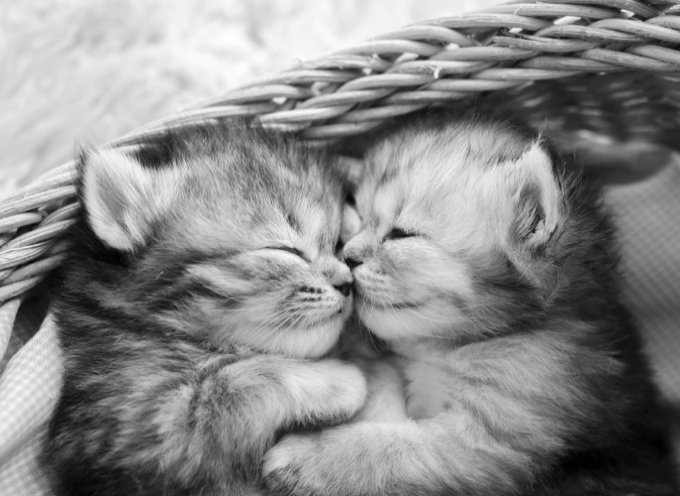

PSNR after DCT / iDCT:  313.7657742220012
% of null coefficients 0.002668406072106262


In [8]:
# "Perfect" reconstruction
compressedimg=np.zeros(greyimg.shape)

for y in range(0,height,8):
    for x in range(0, width,8):
        bloc=dctimg[y:y+8,x:x+8]
        compressedimg[y:y+8,x:x+8]=fftpack.idct(fftpack.idct(bloc,norm='ortho').T,norm='ortho').T

fig = px.imshow(compressedimg, binary_string=True)
fig.update_layout( title_text="'Perfect' reconstruction", title_x=0.5)
fig.show()

print("PSNR after DCT / iDCT: ", metrics.peak_signal_noise_ratio(greyimg,compressedimg))
print("% of null coefficients", 100*(dctimg == 0).sum()/greyimg.size)


**Question 5:** Does the PSNR obtained correspond to the one you expected (theoretically)? What is the reason for this?

**Answer 5**:

It is time to compress our image... For that we will carry out a quantization of the DCT coefficients in order to limit the set of possible values and thus facilitate the compression ( lossless this time) of these simplified coefficients.

DCT coefficients of a 8x8 block after n*Q quantization with n= 4
[[ 704.  -44.  -40.   -0.   -0.   -0.    0.    0.]
 [-192.   48.   -0.   -0.   -0.   -0.   -0.   -0.]
 [   0.   -0.    0.    0.    0.   -0.   -0.   -0.]
 [  -0.   -0.    0.   -0.    0.    0.    0.   -0.]
 [   0.    0.   -0.    0.   -0.   -0.   -0.   -0.]
 [  -0.   -0.   -0.    0.    0.    0.   -0.    0.]
 [   0.   -0.    0.   -0.    0.   -0.    0.   -0.]
 [  -0.    0.   -0.    0.    0.    0.    0.    0.]]
PSNR after DCT / quantification / iDCT:  31.500933142498656
% of null coefficients 94.94722485768501



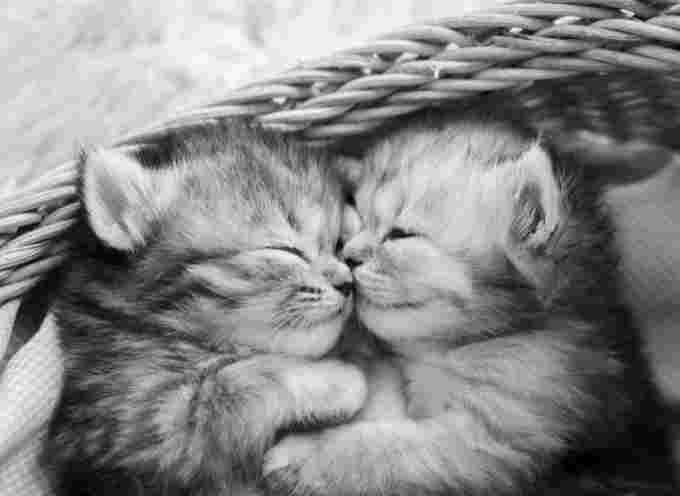

DCT coefficients of a 8x8 block after n*Q quantization with n= 1
[[ 688.  -22.  -30.  -16.   -0.   -0.    0.    0.]
 [-216.   60.  -14.  -19.   -0.   -0.   -0.   -0.]
 [  28.   -0.   16.    0.    0.   -0.   -0.   -0.]
 [ -14.  -17.   22.   -0.    0.    0.    0.   -0.]
 [   0.    0.   -0.    0.   -0.   -0.   -0.   -0.]
 [  -0.   -0.   -0.    0.    0.    0.   -0.    0.]
 [   0.   -0.    0.   -0.    0.   -0.    0.   -0.]
 [  -0.    0.   -0.    0.    0.    0.    0.    0.]]
PSNR after DCT / quantification / iDCT:  36.7680100855446
% of null coefficients 87.03540085388994



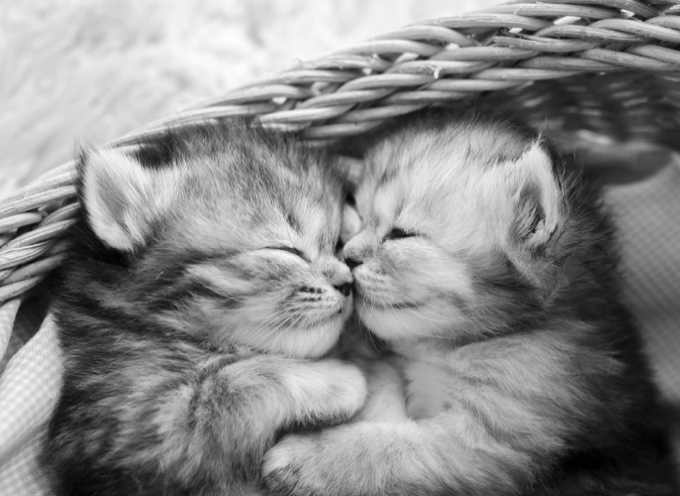

DCT coefficients of a 8x8 block after n*Q quantization with n= 0.5
[[ 688.  -22.  -30.   -8.   -0.  -20.   26.    0.]
 [-216.   60.  -21.  -19.  -13.   -0.  -30.   -0.]
 [  28.   -0.    8.   12.   20.   -0.   -0.   -0.]
 [  -7.  -17.   22.   -0.   26.   44.    0.   -0.]
 [   0.   11.   -0.    0.  -34.   -0.   -0.   -0.]
 [  -0.   -0.   -0.    0.    0.    0.   -0.    0.]
 [   0.   -0.    0.   -0.    0.   -0.    0.   -0.]
 [  -0.    0.   -0.    0.    0.    0.    0.    0.]]
PSNR after DCT / quantification / iDCT:  39.23733141279098
% of null coefficients 81.09760436432637



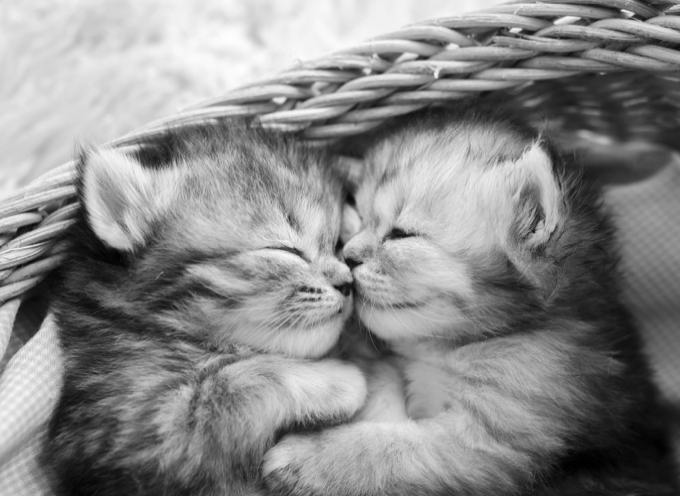

DCT coefficients of a 8x8 block after n*Q quantization with n= 0.1
[[ 685.  -23.  -28.  -10.   -0.  -12.   15.    6.]
 [-215.   59.  -18.  -21.   -8.   -0.  -24.   -6.]
 [  25.   -0.   11.   10.   12.   -6.  -14.   -6.]
 [  -8.  -17.   18.   -6.   15.   26.    8.   -0.]
 [   0.    7.   -7.    6.  -20.   -0.   -0.   -8.]
 [  -5.   -4.   -6.   13.    8.    0.   -0.    0.]
 [  10.   -6.    0.   -9.    0.   -0.    0.   -0.]
 [  -0.    0.   -0.    0.    0.    0.    0.    0.]]
PSNR after DCT / quantification / iDCT:  46.8853642878966
% of null coefficients 61.08811669829222



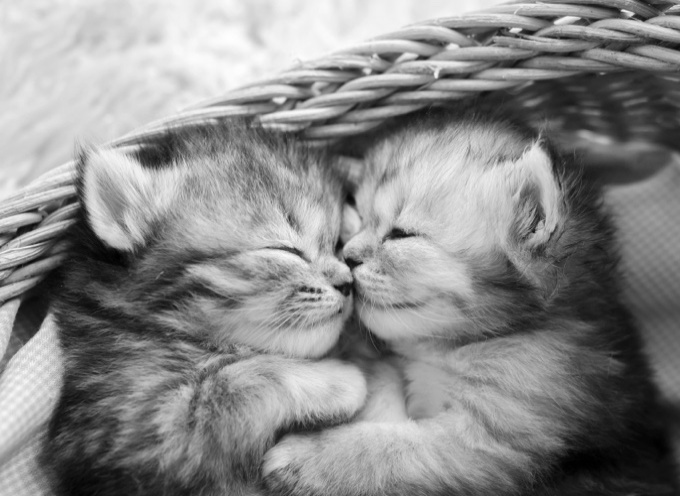

In [9]:
quantized=np.zeros(greyimg.shape)

# the standard JPEG quantization matrix
Q=np.array([[16,11,10,16,24,40,51,61],
            [12,12,14,19,26,48,60,55],
            [14,13,16,24,40,57,69,56],
            [14,17,22,29,51,87,80,62],
            [18,22,37,56,68,109,103,77],
            [24,35,55,64,81,104,113,92],
            [49,64,78,87,103,121,120,101],
            [72,92,95,98,112,100,103,99]])/255

# the different values in N helps generating images of different quality
N=(4, 1, 0.5, 0.1)

for n in N:
    # image quantization et reconstruction
    for y in range(0,height,8):
        for x in range(0, width,8):
            bloc=dctimg[y:y+8,x:x+8]
            quantized[y:y+8,x:x+8]=np.multiply(np.round(np.divide(bloc,n*Q)),n*Q)
            compressedimg[y:y+8,x:x+8]=fftpack.idct(fftpack.idct(quantized[y:y+8,x:x+8],norm='ortho').T,norm='ortho').T

    # truncate too big or low values
    compressedimg[compressedimg>1]=1
    compressedimg[compressedimg<0]=0
    
    # lets display the coefficients of a 8x8 block after quantization
    print("DCT coefficients of a 8x8 block after n*Q quantization with n=",n)
    x=20*8
    y=20*8
    print((255*quantized[y:y+8,x:x+8]).round())
    print("PSNR after DCT / quantification / iDCT: ", metrics.peak_signal_noise_ratio(greyimg,compressedimg))
    print("% of null coefficients", 100*(quantized == 0).sum()/greyimg.size)
    
    fig = px.imshow(compressedimg, binary_string=True)
    fig.update_layout( title_text="Reconstruction after n*Q quantization with n="+str(n), title_x=0.5)
    fig.show()
 


**Question 6:** 
1. Comment on the quantization matrix (contained in variable Q).
2. Observe the percentage of null DCT coefficients ( according to the importance of quantization). Why is this interesting?
3. In JPEG, the DCT coefficients are reordered with a zigzag coding before being compressed (lossless = RLE + Huffman). Why?
![My illustration image](figure/zigzag.jpg)
4. The PSNR is displayed for each case. Try to establish a correspondence between visual quality and PSNR.
5. Do this work on several images, in particular comment the result obtained on the image maths.gif

**Answer 6:**

## Progressive transmission

The script below shows a (simplified) example of how one could transmit DCT coefficients in a progressive way (in a context of transmission on a slow network).


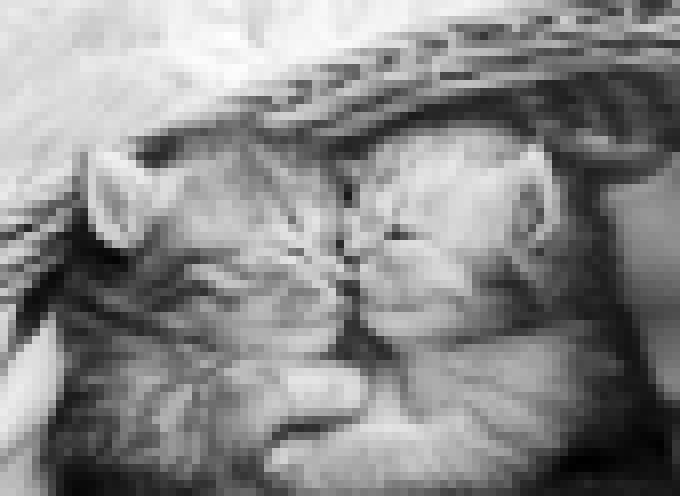

PSNR after the transmission of  3.125 % of the coefficients :  23.665636534265175
% of  null coefficients 98.4375



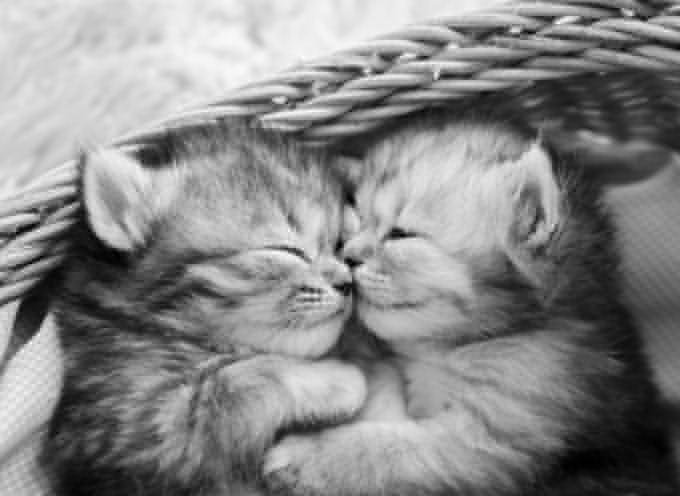

PSNR after the transmission of  10.9375 % of the coefficients :  31.754434814955367
% of  null coefficients 90.86841793168881



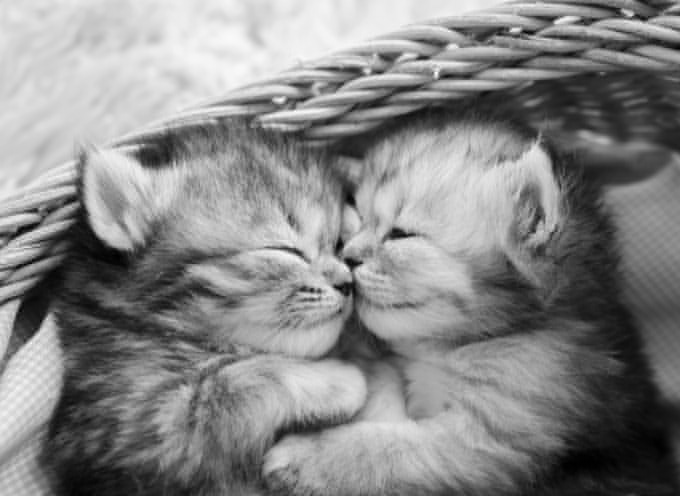

PSNR after the transmission of  18.75 % of the coefficients :  34.31907880950979
% of  null coefficients 84.2359463946869



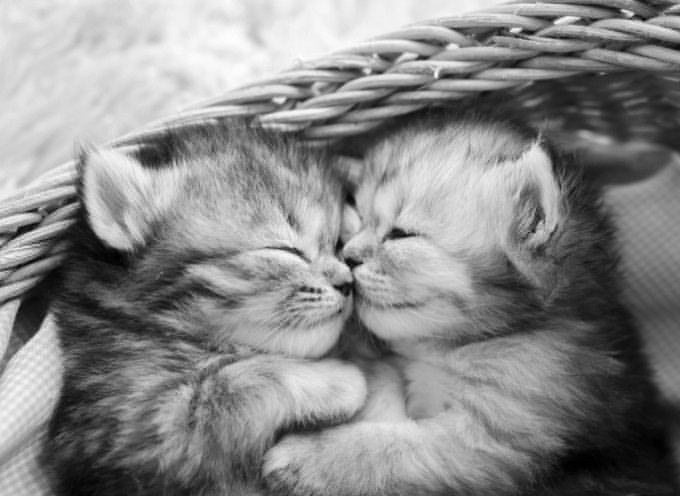

PSNR after the transmission of  26.5625 % of the coefficients :  36.57136389422551
% of  null coefficients 78.15879981024668



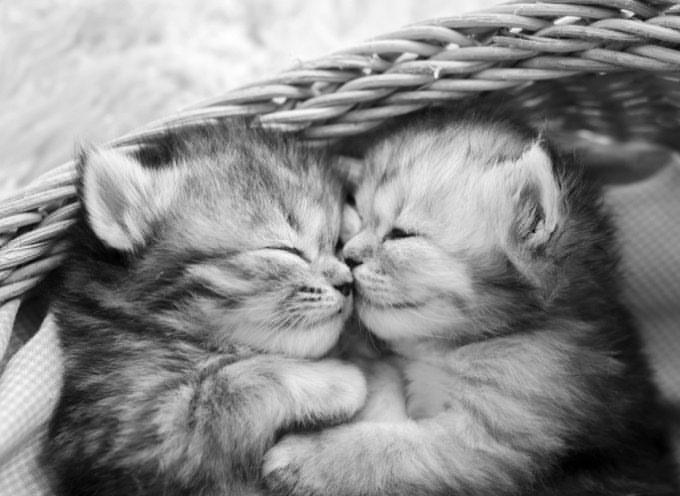

PSNR after the transmission of  34.375 % of the coefficients :  38.46726394157241
% of  null coefficients 73.1131404174573



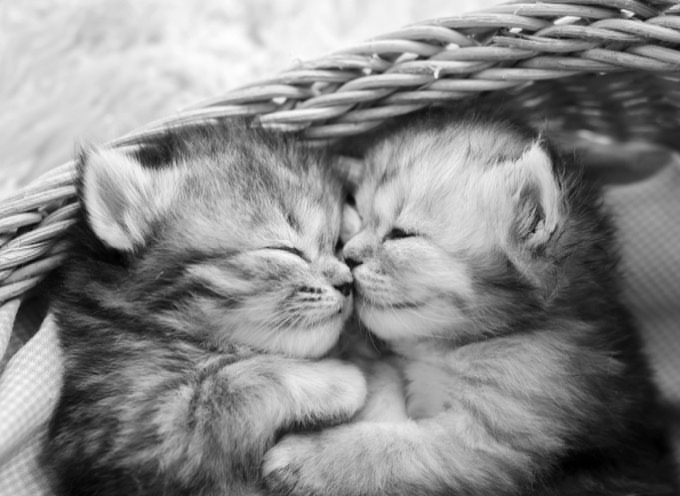

PSNR after the transmission of  42.1875 % of the coefficients :  40.0557485037768
% of  null coefficients 69.50249051233396



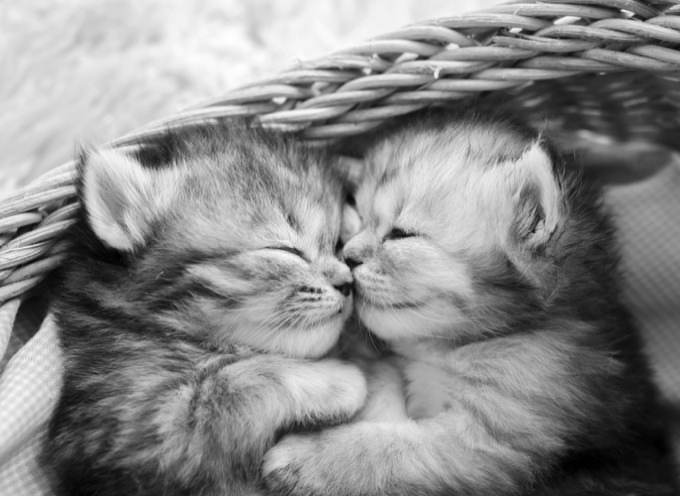

PSNR after the transmission of  50.0 % of the coefficients :  41.08583835059928
% of  null coefficients 67.22960151802657



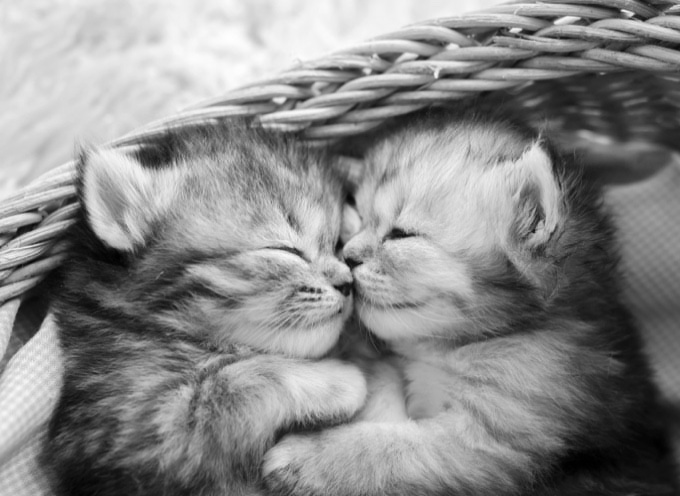

PSNR after the transmission of  57.8125 % of the coefficients :  42.775178649999965
% of  null coefficients 64.89000237191651



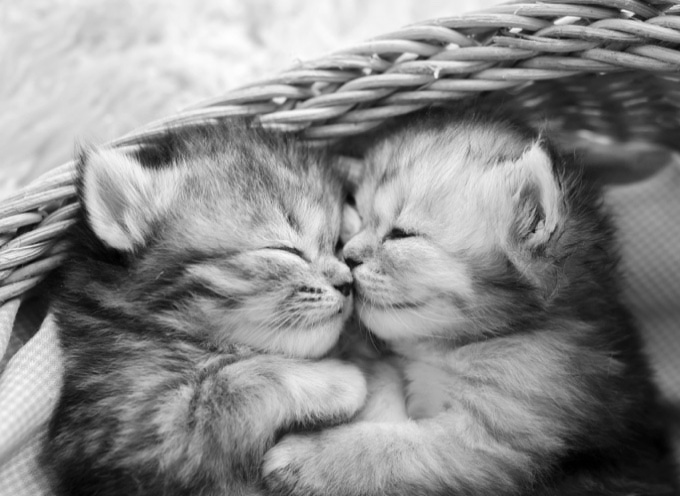

PSNR after the transmission of  65.625 % of the coefficients :  44.21555808512662
% of  null coefficients 63.29459203036053



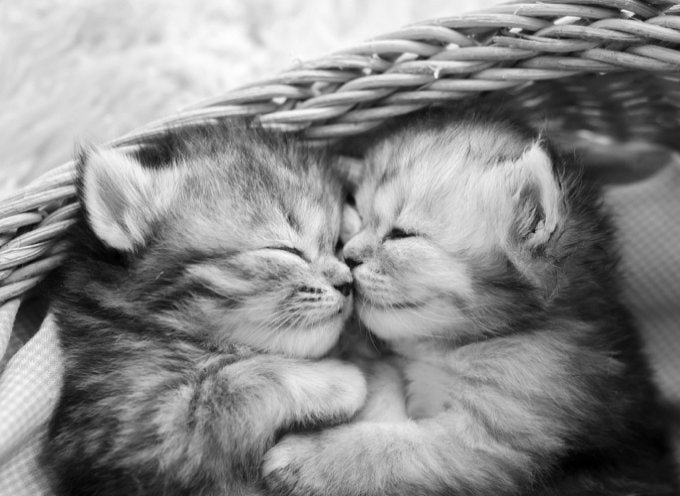

PSNR after the transmission of  73.4375 % of the coefficients :  44.92552031051674
% of  null coefficients 62.5690820683112



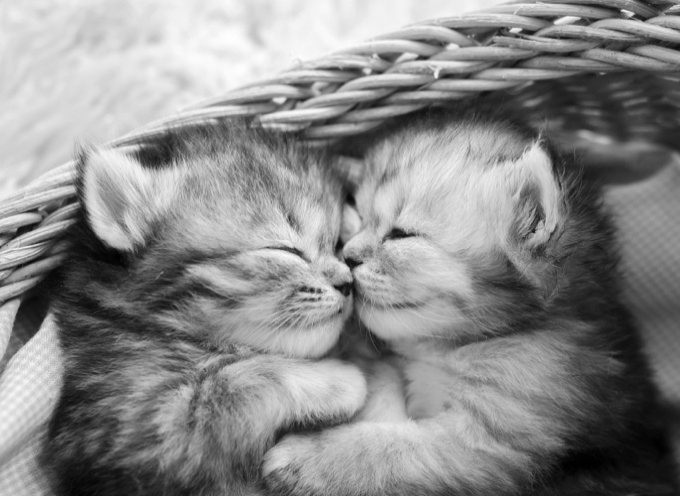

PSNR after the transmission of  81.25 % of the coefficients :  46.072925477994524
% of  null coefficients 61.67664848197344



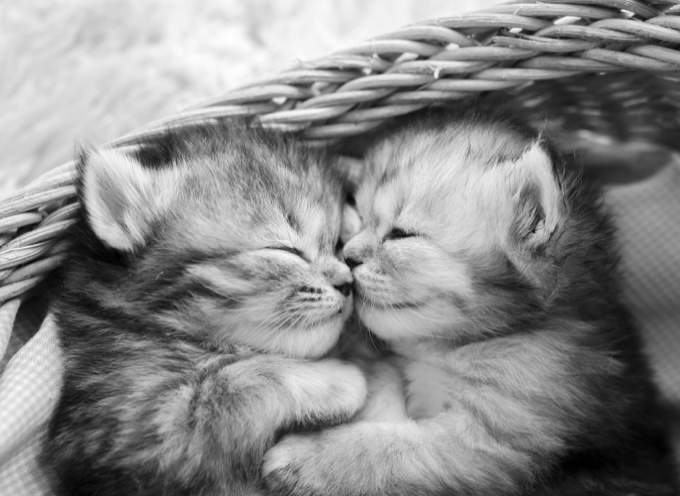

PSNR after the transmission of  89.0625 % of the coefficients :  46.44557593154783
% of  null coefficients 61.40387808349146



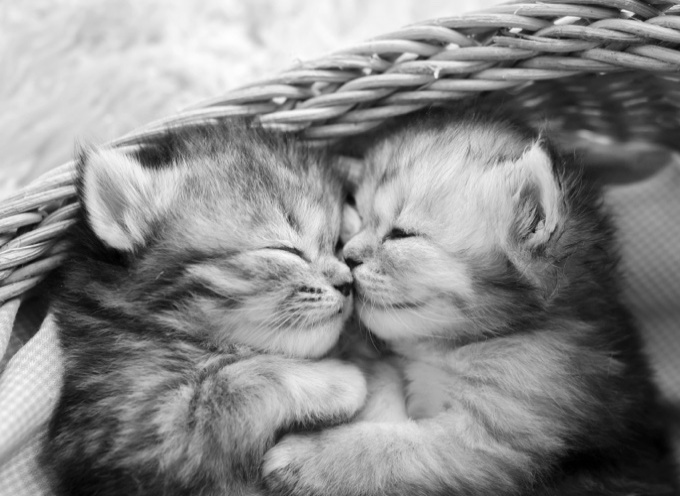

PSNR after the transmission of  96.875 % of the coefficients :  46.82509509283357
% of  null coefficients 61.13792694497154


In [10]:
# "Progressive" JPEG

zigzagorder = [ 1,  9,  2,  3,  10, 17, 25, 18, 11, 4,  5,  12, 19, 26, 33, 41, 34, 27, 20, 13, 6,  7,  14, 21, 28, 35, 42, 49, 57, 50, 43, 36, 29, 22, 15, 8,  16, 23, 30, 37, 44, 51, 58, 59, 52, 45, 38, 31, 24, 32, 39, 46, 53, 60, 61, 54, 47, 40, 48, 55, 62, 63, 56, 64]

# we have 13 progressive transmission levels
for level in range(1, 64, 5):
    # We proceed block by block
    for y in range(0,height*8//8,8):
        for x in range(0, width*8//8,8):
            bloc=np.zeros((8,8))
            # And keep only part of the data
            for i in range(0,level):
                yy=(zigzagorder[i]-1)//8
                xx=(zigzagorder[i]-1)%8
                bloc[yy,xx]=dctimg[y+yy,x+xx]
            quantized[y:y+8,x:x+8]=np.multiply(np.round(np.divide(bloc,Q*0.1)),Q*0.1)
            compressedimg[y:y+8,x:x+8]=fftpack.idct(fftpack.idct(quantized[y:y+8,x:x+8],norm='ortho').T,norm='ortho').T
    
    # truncate too big or low values
    compressedimg[compressedimg>1]=1
    compressedimg[compressedimg<0]=0
    
    fig = px.imshow(compressedimg, binary_string=True)
    fig.update_layout( title_text="Reconstruction after the transmission of "+ str(100*(level+1)/64) + "% of the coefficients", title_x=0.5)
    fig.show()
    
    print("PSNR after the transmission of ", str(100*(level+1)/64),  "% of the coefficients : ", metrics.peak_signal_noise_ratio(greyimg,compressedimg))
    print("% of  null coefficients", 100*(quantized == 0).sum()/greyimg.size)

**Question 7:** 
1. What is the principle of this progressive transmission?
2. Test it on different types of images (and in particular maths.gif). Is this method suitable for any type of content?

**Answer 7:**

## Encoding of zero-frequency DCT coefficients

In JPEG, DCT coefficients of zero frequency (DC component) undergo DPCM encoding. The script below should help you understand why.


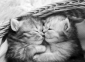

mean value, standard deviation of the zero-frequency coefficient of all the blocks:  4.2297231295835305 1.9771565925203232



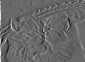

mean value, standard deviation  of the DC component of each block after DPCM coding:  -0.0011678728841784613 0.7491648526714865


In [11]:
# We only keep DC coefficients
coefscont=np.zeros((height//8, width//8))
for y in range(0,height*8//8,8):
    for x in range(0, width*8//8,8):
        coefscont[y//8,x//8] = dctimg[y,x]
        
fig = px.imshow(coefscont, binary_string=True)
fig.update_layout( title_text="zero-frequezncy coefficients", title_x=0.5)
fig.show()
print("mean value, standard deviation of the zero-frequency coefficient of all the blocks: ", coefscont.mean(), coefscont.std())

# different between one zero-frequency coefficient and the previous one
reshapeddc=coefscont.reshape((width*height//64,1))
dpcmcoefs=np.zeros(width*height//64)
for i in range(1,width*height//64):
    dpcmcoefs[i]=reshapeddc[i]-reshapeddc[i-1]
coefscont=dpcmcoefs.reshape((height//8,width//8))

fig = px.imshow(coefscont, binary_string=True)
fig.update_layout( title_text="Differnce with the previous coefficient (left)", title_x=0.5)
fig.show()
print("mean value, standard deviation  of the DC component of each block after DPCM coding: ", dpcmcoefs.mean(), dpcmcoefs.std())


**Question 8:**  Observe the results of the script in order to:
1. Explain what DPCM coding is
2. Justify the interest of this coding for zero frequency coefficients.

**Answer 8:**

## Transmission errors correction

A good decoder must be a good (and fast) error concealer: the script below sets to zero some blocks of DCT coefficients in the image, simulating very roughly transmission problems.


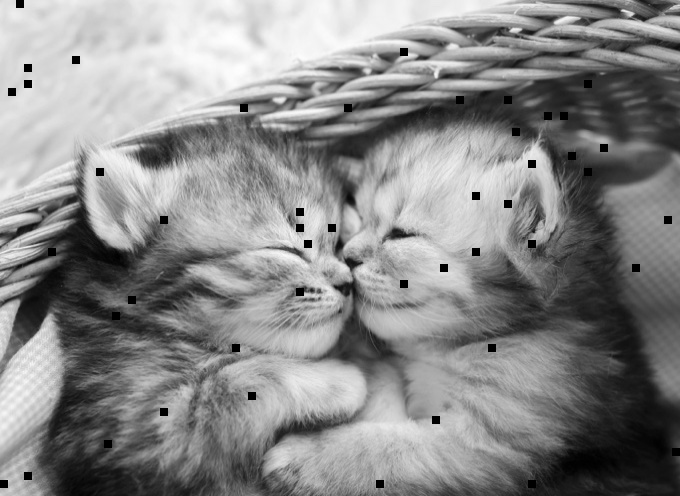

PSNR after errors:  25.12888834108834


In [12]:
# We simulate packet loss
dcterror=quantized.copy()
probaerror=0.01
for y in range(0,height,8):
    for x in range(0, width,8):
        if random.random() <= probaerror:
            dcterror[y:y+8,x:x+8] = 0;

# write here your error concealment code
# your code here !!!

# image reconstruction
for y in range(0,height,8):
    for x in range(0, width,8):
        compressedimg[y:y+8,x:x+8]=fftpack.idct(fftpack.idct(dcterror[y:y+8,x:x+8],norm='ortho').T,norm='ortho').T

fig = px.imshow(compressedimg, binary_string=True)
fig.update_layout( title_text="Image with missing blocks", title_x=0.5)
fig.show()
print("PSNR after errors: ", metrics.peak_signal_noise_ratio(greyimg,compressedimg))

**Question 9:** 
1. Which technique could be used to mask (partially) these errors before decoding the image ?
2. Implement your technique in the above script and see (hopefully) the improvement of the PSNR

**Answer 9:**

## Decoding improvement

You may have noticed that when the compression rate of a JPEG image is high, you can clearly see the transition between the different 8x8 blocks of the image.

**Question 10:** 
1. How could the image be improved during decoding to mitigate these transitions?
2. Should the way this filtering is done be included in the JPEG standard?

**Answer 10:**

## Bonus : dithering

We saw in this tutorial that the quantization of DCT coefficients was much more efficient than the quantization of pixel values (as done in image processing tutorials) to achieve a high compression but preserving the quality of the image.
There is however a way to improve the quality of the direct quantization of the pixel values: dithering...


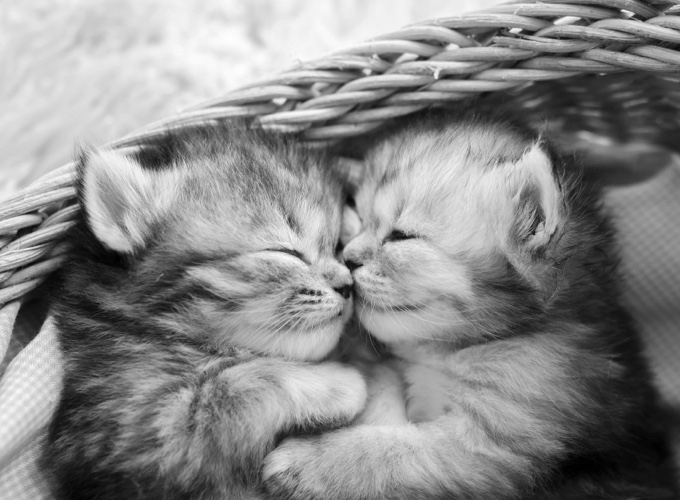


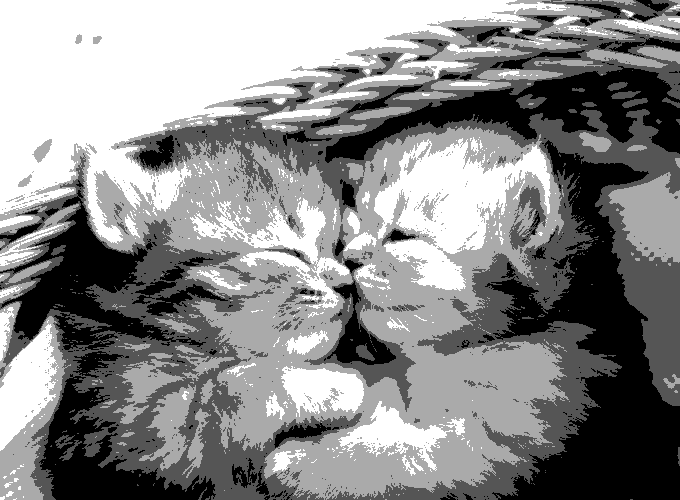


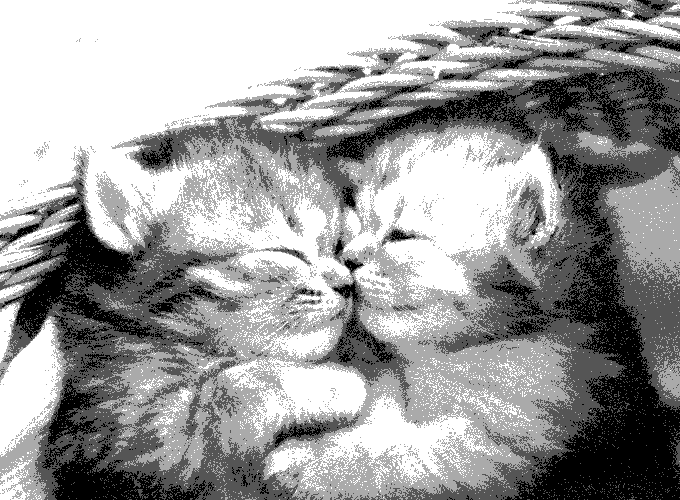


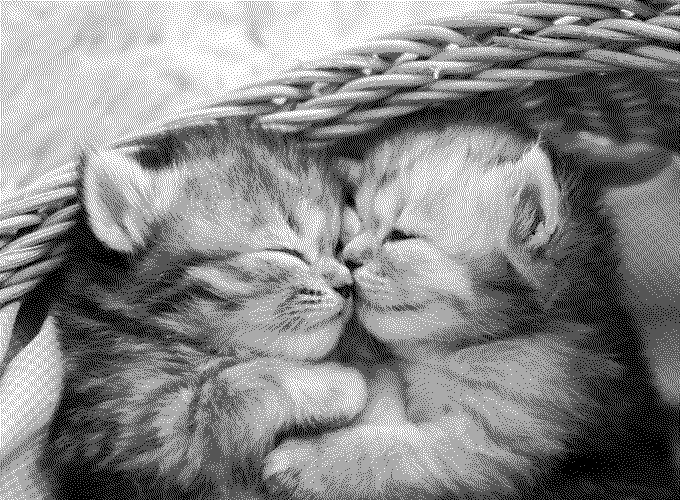

0.9814862745098039 1.0
PSNR quantization:  17.844233987781276
PSNR dithering: Image + Noise:  16.081414006562632
PSNR Floyd-Steinberg:  17.267212768078007


In [13]:
from skimage.filters import threshold_otsu

def quantize(image, L=1, N=4):
    T = np.linspace(0, L, N, endpoint=False)[1:]
    return np.digitize(image.flat, T).reshape(image.shape)/(N-1)


def dither(image, N=4, positions=None, weights=None):
    """Quantize an image, using dithering.
    Parameters
    ----------
    image : ndarray
        Input image.
    N : int
        Number of quantization levels.
    positions : list of (i, j) offsets
        Position offset to which the quantization error is distributed.
        By default, implement Sierra's "Filter Lite".
    weights : list of ints
        Weights for propagated error.
        By default, implement Sierra's "Filter Lite".
    References
    ----------
    http://www.efg2.com/Lab/Library/ImageProcessing/DHALF.TXT
    """
    image = image.copy()

    if positions is None or weights is None:
        positions = [(0, 1), (1, -1), (1, 0)]
        weights = [2, 1, 1]

    weights = weights / np.sum(weights)

    T = np.linspace(0, 1, N, endpoint=False)[1:]
    rows, cols = image.shape

    out = np.zeros_like(image, dtype=float)
    for i in range(rows):
        for j in range(cols):
            # Quantize
            out[i, j], = np.digitize([image[i, j]], T)

            # Propagate quantization noise
            d = (image[i, j] - out[i, j] / (N - 1))
            for (ii, jj), w in zip(positions, weights):
                ii = i + ii
                jj = j + jj
                if ii < rows and jj < cols:
                    image[ii, jj] += d * w

    return out/(N-1)


def floyd_steinberg(image, N):
    offsets = [(0, 1), (1, -1), (1, 0), (1, 1)]
    weights = [      7,
               3, 5, 1]
    return dither(image, N, offsets, weights)

# Image with 255 color levels
img = color.rgb2gray(io.imread('chat.jpg'))

# Quantize to N levels
N = 4
img_quant = quantize(img, N=N)

img_dither_random = img + np.abs(np.random.normal(size=img.shape,
                                           scale=1./(3 * N)))
img_dither_random = quantize(img_dither_random, L=1, N=N)

img_dither_fs = floyd_steinberg(img, N=N)

fig = px.imshow(img, binary_string=True)
fig.update_layout( title_text="Source image", title_x=0.5)
fig.show()
fig = px.imshow(img_quant, binary_string=True)
fig.update_layout( title_text="Quantization (N=%d)" % N, title_x=0.5)
fig.show()
fig = px.imshow(img_dither_random, binary_string=True)
fig.update_layout( title_text="Quantization: Image + Noise", title_x=0.5)
fig.show()
fig = px.imshow(img_dither_fs, binary_string=True)
fig.update_layout( title_text="Floyd-Steinberg", title_x=0.5)
fig.show()

print(img.max(), img_quant.max())
print("PSNR quantization: ", metrics.peak_signal_noise_ratio(img,img_quant))
print("PSNR dithering: Image + Noise: ", metrics.peak_signal_noise_ratio(img,img_dither_random))
print("PSNR Floyd-Steinberg: ", metrics.peak_signal_noise_ratio(img,img_dither_fs))

**Bonus Question:**
1. Compare the PSNR scores obtained and your own judgment of image quality. How do you explain this result?
2. What is the principle of dithering (Floyd-Steinberg)?
3. This is not a question... but there is another technique close to dithering but used by printers: halftoning. It is interesting to see how it works.

**Bonus answer:**